In [65]:
from project_insider_helper import *
import pandas as pd
from pandas_datareader import data
import numpy as np
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import statistics as st
sns.set(context = 'paper')

In [64]:
# import sys
# sys.modules.pop('project_insider_helper')

<module 'project_insider_helper' from '/Users/mdrozdov/Documents/insider/web_scraping_insider_trading/project_insider_helper.py'>

In [2]:
with open('tickers.txt','r') as file:
    tickers = file.readlines()
    
tickers = [item.strip() for item in tickers]

In [3]:
columns = ['transaction_date', 'transaction_type', 'company_name',
           'ticker', 'name', 'position', 'shares_traded', 'avg_price',
           'total_price', 'shares_owned', 'own_type']

dict_insiders = file_readr(tickers, columns = columns)


### cleaning insiders dictionary 

In [5]:
dict_insiders = clean_dict(dict_insiders)

FCX cleaned successfully
MAS cleaned successfully
HAS cleaned successfully
AMZN cleaned successfully
MU cleaned successfully
VAR cleaned successfully
PEG cleaned successfully
LEG cleaned successfully
JBHT cleaned successfully
CAT cleaned successfully
K cleaned successfully
HES cleaned successfully
NDAQ cleaned successfully
BLL cleaned successfully
AAP cleaned successfully
VTR cleaned successfully
PG cleaned successfully
NSC cleaned successfully
PBCT cleaned successfully
AMAT cleaned successfully
MAR cleaned successfully
INCY cleaned successfully
ORLY cleaned successfully
ROL cleaned successfully
JWN cleaned successfully
NEE cleaned successfully
QRVO cleaned successfully
CVX cleaned successfully
HUM cleaned successfully
NBL cleaned successfully
BDX cleaned successfully
AWK cleaned successfully
SJM cleaned successfully
PXD cleaned successfully
CHD cleaned successfully
AMP cleaned successfully
DRI cleaned successfully
AEE cleaned successfully
ABMD cleaned successfully
CTXS cleaned success

### fetching and cleaning stock price data

In [6]:
stocks_dict_pre = get_stocks(dict_insiders)

In [7]:
stocks_dict = clean_stocks(stocks_dict_pre)

In [36]:
stocks_dict['FCX'].return_std.describe()

count    822.000000
mean       0.557802
std        0.388651
min        0.035435
25%        0.282002
50%        0.458431
75%        0.718838
max        2.647149
Name: return_std, dtype: float64

### merging and cleaning insider & stock data

In [66]:
full_dict = merge_dicts(dict_insiders,stocks_dict)

/Users/mdrozdov/Documents/insider/web_scraping_insider_trading/project_insider_helper.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  full_df.sale_num[full_df.sale_num > 0] = 1
/Users/mdrozdov/Documents/insider/web_scraping_insider_trading/project_insider_helper.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  full_df.buy_num[full_df.buy_num>0] = 1


### class balance dataframe

In [71]:
label_col = 'risk_dummy'
columns = ['Ticker','Low_Risk','High_Risk']

class_balance_df = create_class_balance_df(full_dict, label_col, columns)
class_balance_df[class_balance_df['High_Risk_Pct']<2]

,Ticker,Low_Risk,High_Risk,Sample_Size,Low_Risk_Pct,High_Risk_Pct
1,MAS,779,2.0,781.0,99.743918,0.256082
6,PEG,811,3.0,814.0,99.631450,0.368550
7,LEG,818,5.0,823.0,99.392467,0.607533
10,K,830,11.0,841.0,98.692033,1.307967
13,BLL,806,1.0,807.0,99.876084,0.123916
16,PG,807,14.0,821.0,98.294762,1.705238
19,AMAT,768,3.0,771.0,99.610895,0.389105
31,AWK,542,10.0,552.0,98.188406,1.811594
34,CHD,810,4.0,814.0,99.508600,0.491400
37,AEE,806,3.0,809.0,99.629172,0.370828


### plotting insider trades

/Users/mdrozdov/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


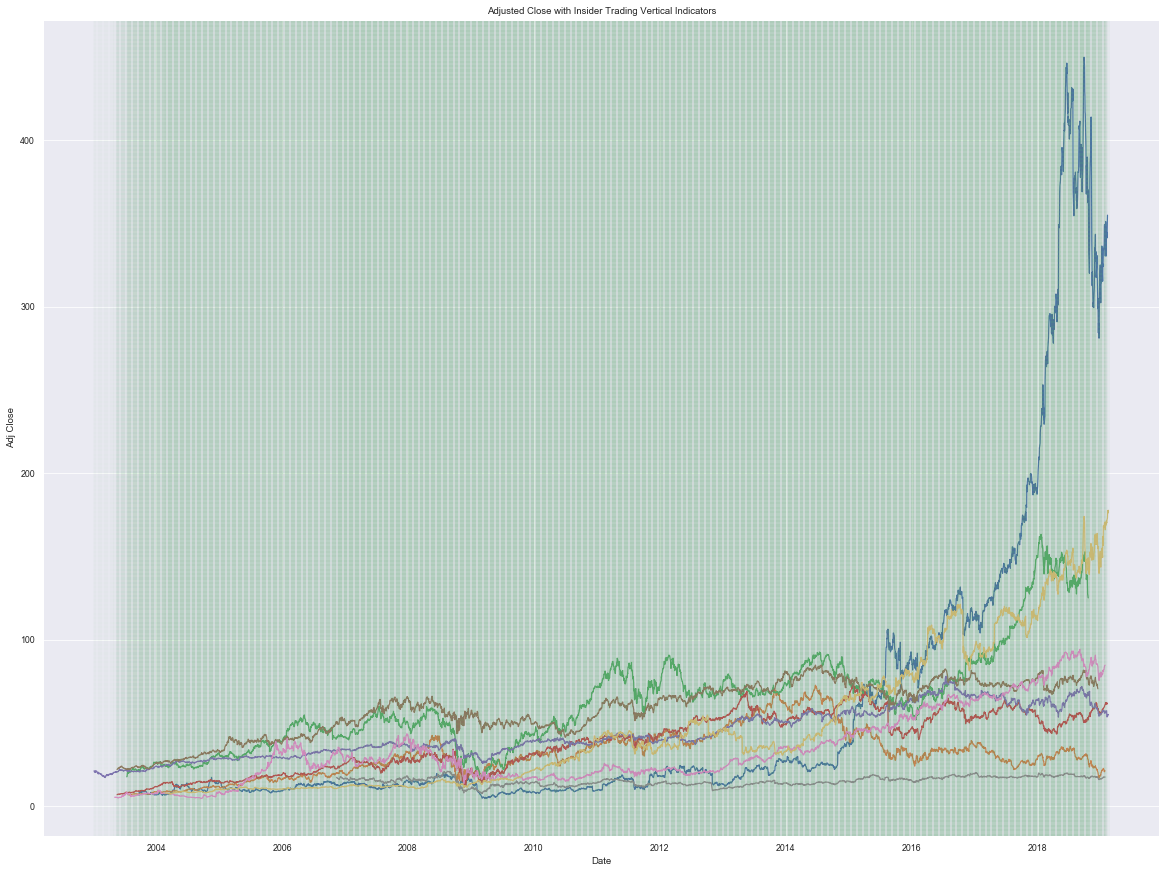

In [10]:
plot_dict(dict_insiders,stocks_dict_pre,10)

### fitting model

In [363]:
models_dict = model_dict(full_dict)

FCX
MAS
HAS
AMZN
MU
VAR
PEG
LEG
JBHT
CAT
K
HES
NDAQ
BLL
AAP
VTR
PG
NSC
PBCT
AMAT
MAR
INCY
ORLY
ROL
JWN
NEE
QRVO
CVX
HUM
NBL
BDX
AWK
SJM
PXD
CHD
AMP
DRI
AEE
ABMD
CTXS
HSY
MDLZ
UNH
UDR
CCI
VRSK
AEP
JNJ
LOW
CMCSA
MMM
PPG
ADP
AJG
EW
AZO
SNA
ALB
CHRW
UPS
FDX
DISH
MTD
FAST
ROP
LNT
XOM
WU
PRU
COO
CPRI
CSX
ABT
